<a href="https://colab.research.google.com/github/zwubbena/sample-size-tables/blob/main/sample_size_moe_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

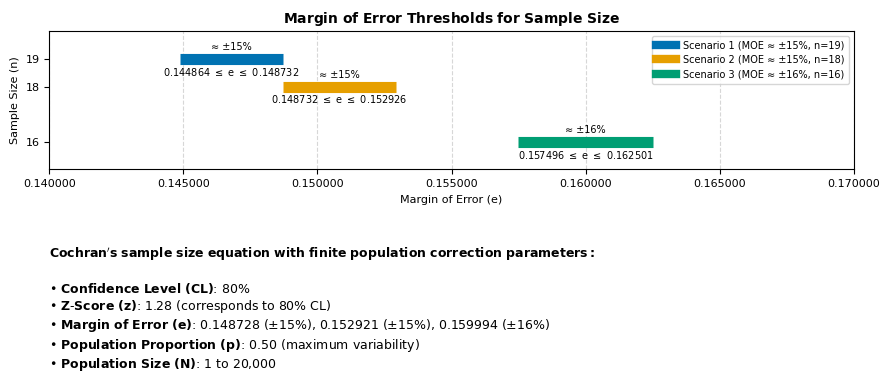

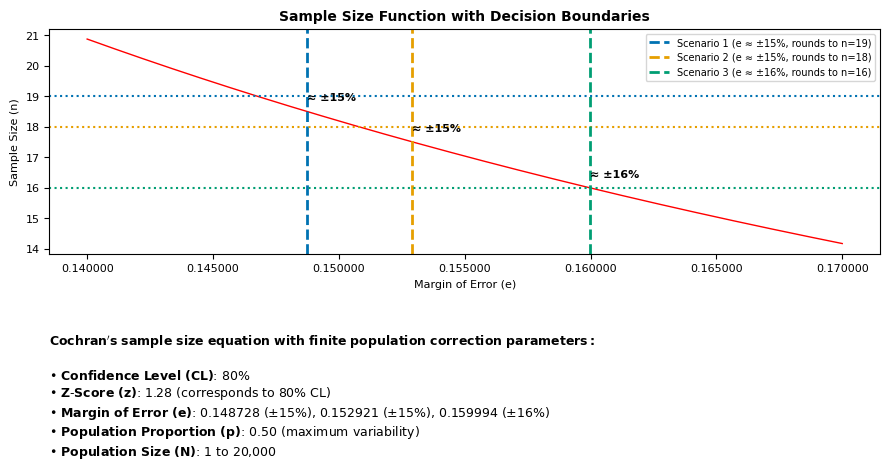

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
# =============================================================================
# Script Name : sample_size_moe_graphs.ipynb
# Purpose     : Generate a Margin of Error Thresholds for Sample Size
#               graph and Sample Size Function with Decision Boundaries
#               graph and exports both to a single PDF.
# Author      : Zane Wubbena, PhD
# Date        : 2025-08-07
# =============================================================================

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FormatStrFormatter
from google.colab import files

# -------------------------------
# Statistical Parameters (edit here)
# -------------------------------
CL = 0.80          # Confidence Level
Z = 1.28           # z-score for 80%
p = 0.50           # population proportion (max variability)
N = 20000          # population size upper bound for calc

# Margin of Error scenarios (decimal form) — EDIT THESE THREE
moe_scenarios = [
    (0.148728, 'Scenario 1'),  # ~±15%
    (0.152921, 'Scenario 2'),  # ~±15%
    (0.159994, 'Scenario 3')   # ~±16%
]

# Colors (Okabe–Ito: color-blind–friendly)
colors = ['#0072B2', '#E69F00', '#009E73']  # blue, orange, green

# X-range for plotting e (MOE)
E_MIN, E_MAX = 0.14, 0.17

# ------------------------
# Core math (Cochran + FPC)
# ------------------------
def n_fpc(N, Z, p, e):
    """Sample size with finite population correction (unrounded)."""
    n0 = (Z**2 * p * (1 - p)) / (e**2)
    return n0 / (1 + (n0 - 1) / N)

def round_half_up(x):
    """Round half up to nearest integer (avoid bankers' rounding)."""
    return int(math.floor(x + 0.5))

# -----------------------------------------------------
# Find the e-range where the rounded n equals n_target
# -----------------------------------------------------
def e_interval_for_integer_n(n_target, e0, N, Z, p, e_lo=0.05, e_hi=0.5, tol=1e-7, max_steps=200):
    """
    Given a target integer sample size n_target and a seed e0 (where it rounds to that n),
    find the maximal interval [a, b] in e such that round_half_up(n_fpc(N,Z,p,e)) == n_target.
    """
    def f(e):
        return round_half_up(n_fpc(N, Z, p, e)) - n_target

    # Safety clamp
    e0 = float(np.clip(e0, e_lo, e_hi))
    if f(e0) != 0:
        # Try to nudge toward a nearby zero with a quick local search
        scan = np.linspace(max(e_lo, e0-0.01), min(e_hi, e0+0.01), 401)
        zeros = [e for e in scan if f(e) == 0]
        if not zeros:
            # As a fallback, search the full domain coarsely
            scan = np.linspace(e_lo, e_hi, 5001)
            zeros = [e for e in scan if f(e) == 0]
            if not zeros:
                return None, None
        e0 = zeros[len(zeros)//2]

    # Expand left until it changes
    left = e0
    step = 0.001
    while left - step >= e_lo and f(left - step) == 0:
        left -= step
    # Bisection to boundary on left
    L, R = e_lo, left
    if f(L) == 0:
        a = L
    else:
        # Find point where it flips from nonzero to zero
        low, high = L, left
        for _ in range(max_steps):
            mid = (low + high) / 2
            if f(mid) == 0:
                high = mid
            else:
                low = mid
            if high - low < tol:
                break
        a = high

    # Expand right until it changes
    right = e0
    while right + step <= e_hi and f(right + step) == 0:
        right += step
    # Bisection to boundary on right
    L, R = right, e_hi
    if f(R) == 0:
        b = R
    else:
        low, high = right, R
        for _ in range(max_steps):
            mid = (low + high) / 2
            if f(mid) == 0:
                low = mid
            else:
                high = mid
            if high - low < tol:
                break
        b = low

    # Clamp to plotting domain if desired
    return max(a, E_MIN), min(b, E_MAX)

# --------------------------------
# Parameter list text (dynamic MOE)
# --------------------------------
def param_bullets(CL, Z, p, N, moe_scenarios):
    moe_list = ", ".join([f"{e:.6f} (±{e*100:.0f}%)" for e, _ in moe_scenarios])
    lines = [
        rf"$\mathbf{{Cochran's\ sample\ size\ equation\ with\ finite\ population\ correction\ parameters:}}$",
        "",  # blank line after title
        rf"• $\mathbf{{Confidence\ Level\ (CL)}}$: {int(CL*100)}%",
        rf"• $\mathbf{{Z\text{{-}}Score\ (z)}}$: {Z} (corresponds to {int(CL*100)}% CL)",
        rf"• $\mathbf{{Margin\ of\ Error\ (e)}}$: {moe_list}",
        rf"• $\mathbf{{Population\ Proportion\ (p)}}$: {p:.2f} (maximum variability)",
        rf"• $\mathbf{{Population\ Size\ (N)}}$: 1 to {N:,}",
    ]
    return "\n".join(lines)

param_text = param_bullets(CL, Z, p, N, moe_scenarios)

# ----------------------------------------------------
# Graph 1: Margin of Error Thresholds for Sample Size
# ----------------------------------------------------
def plot_moe_thresholds(ax):
    """
    For each scenario's MOE (e_i), compute the integer sample size n_i = round_half_up(n_fpc(..., e_i)),
    then compute the full e-interval where the rounded n equals n_i and draw a horizontal bar.
    """
    # Title
    title = "Margin of Error Thresholds for Sample Size"
    ax.set_title(r"$\mathbf{Margin\ of\ Error\ Thresholds\ for\ Sample\ Size}$", fontsize=10)

    # Compute bars
    legend_entries = []
    y_vals = []
    bars = []
    for (e_i, label), color in zip(moe_scenarios, colors):
        n_i = round_half_up(n_fpc(N, Z, p, e_i))
        a, b = e_interval_for_integer_n(n_i, e_i, N, Z, p, e_lo=0.05, e_hi=0.5)
        if a is None or b is None or a >= b:
            # Fallback: draw a tiny bar centered at e_i
            a, b = e_i - 0.0005, e_i + 0.0005
        y = n_i
        y_vals.append(y)
        bars.append((a, b, y, color, label, e_i))

        # Legend name: bold scenario name with MOE %
        legend_entries.append((f"{label} (MOE ≈ ±{e_i*100:.0f}%, n={n_i})", color))

    # Draw bars
    for (a, b, y, color, label, e_i) in bars:
        ax.hlines(y=y, xmin=a, xmax=b, colors=color, linewidth=8)

        # TOP: MOE percent (keep above the bar)
        ax.text((a + b) / 2, y + 0.32, f"≈ ±{e_i*100:.0f}%",
                color='black', fontsize=7, ha='center')

        # BOTTOM: e-range (move below the bar)
        ax.text((a + b) / 2, y - 0.6,
                rf"{a:.6f} $\leq$ e $\leq$ {b:.6f}",
                color='black', fontsize=7, ha='center')

        # ax.text((a + b) / 2, y - 0.6, f"{a:.6f} – {b:.6f}",
                # color='black', fontsize=7, ha='center')

    # x-axis label
    ax.set_xlabel("Margin of Error (e)", fontsize=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.6f'))

    # y-axis label
    ax.set_ylabel("Sample Size (n)", fontsize=8)

    # Tick labels (x-axis and y-axis values)
    ax.tick_params(axis='x', labelsize=8)  # smaller numbers on x-axis
    ax.tick_params(axis='y', labelsize=8)  # smaller n

    # Set x-axis range to match MOE limits and y-axis ticks to show only actual sample sizes
    ax.set_xlim(E_MIN, E_MAX)
    ax.set_yticks(sorted(set(y_vals)))

    # Cushion the y-axis range by one sample size below min and above max
    ax.set_ylim(min(y_vals) - 1, max(y_vals) + 1)

    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Legend
    handles = []
    for name, color in legend_entries:
        handles.append(plt.Line2D([0], [0], color=color, lw=6, label=name))
    ax.legend(handles=handles, fontsize=7, frameon=True)

    # Parameter list under plot
    ax.text(0, -0.55, param_text, transform=ax.transAxes, fontsize=9, va='top', ha='left', wrap=True)

# ------------------------------------------------------
# Graph 2: Sample Size Function with Decision Boundaries
# ------------------------------------------------------
def plot_sample_size_function(ax):
    title = "Sample Size Function with Decision Boundaries"
    ax.set_title(title, fontsize=10, fontweight='bold')

    e_values = np.linspace(E_MIN, E_MAX, 600)
    n_vals = [n_fpc(N, Z, p, e) for e in e_values]
    ax.plot(e_values, n_vals, color='red', linewidth=1, label='Sample Size Function')

    # Decision boundaries per scenario
    legend_entries = []
    for (e_i, label), color in zip(moe_scenarios, colors):
        n_i = n_fpc(N, Z, p, e_i)
        n_int = round_half_up(n_i)
        ax.axvline(x=e_i, color=color, linestyle='--', linewidth=2)
        ax.axhline(y=n_int, color=color, linestyle=':', linewidth=1.5)
        ax.text(e_i, n_i + 0.35, f"≈ ±{e_i*100:.0f}%", color='black', fontsize=8, fontweight='bold', ha='left')

        legend_entries.append((f"{label} (e ≈ ±{e_i*100:.0f}%, rounds to n={n_int})", color))

    # x-axis label
    ax.set_xlabel("Margin of Error (e)", fontsize=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.6f'))

    # y-axis label
    ax.set_ylabel("Sample Size (n)", fontsize=8)

    # Tick labels (x-axis and y-axis values)
    ax.tick_params(axis='x', labelsize=8)  # smaller numbers on x-axis
    ax.tick_params(axis='y', labelsize=8)  # smaller n

    # ax.grid(False, linestyle='--', alpha=0.5)
    ax.grid(False)

    # Legend
    handles = []
    for name, color in legend_entries:
        handles.append(plt.Line2D([0], [0], color=color, lw=2, linestyle='--', label=name))
    ax.legend(handles=handles, fontsize=7, frameon=True)

    # Parameter list under plot
    ax.text(0, -0.35, param_text, transform=ax.transAxes, fontsize=9, va='top', ha='left', wrap=True)

# ----------------------
# Generate PDF and plots
# ----------------------
pdf_filename = "Sample_Size_Margin_of_Error_Graphs.pdf"
with PdfPages(pdf_filename) as pdf:
    # Page 1
    fig1, ax1 = plt.subplots(figsize=(9, 5.5))
    plot_moe_thresholds(ax1)
    plt.tight_layout()
    pdf.savefig(fig1)
    plt.show()

    # Page 2
    fig2, ax2 = plt.subplots(figsize=(9, 5.5))
    plot_sample_size_function(ax2)
    plt.tight_layout()
    pdf.savefig(fig2)
    plt.show()

# Download PDF in Colab
files.download(pdf_filename)
